<h1 style="font-family:verdana;"> <center>🛍 OTTO – Multi-Objective Recommender System - Getting Started 🧑‍💻</center> </h1>

***

### <span style="font-family:verdana; word-spacing:1.5px;"> Contents:
[Load in the data ⏳](#first-bullet)
    
[Data Structure 🗂](#second-bullet)
    
[Intital EDA 📊](#third-bullet)
    
[Baseline 📈](#fourth-bullet)
    
[Where to go next 🚀](#fith-bullet)

### <span style="font-family:verdana; word-spacing:1.5px;">  Task overview
    
<span style="font-family:verdana; word-spacing:1.5px;">  The aim of this competition is to predict e-commerce <span style="color:#159364;">clicks, cart additions, and orders</span>. You'll build a multi-objective recommender system based on previous events in a user session.
    
<span style="font-family:verdana; word-spacing:1.5px;"> Current recommender systems consist of various models with different approaches, ranging from simple matrix factorization to a transformer-type deep neural network. However, no single model exists that can simultaneously optimize multiple objectives. In this competition, you’ll build a single entry to predict click-through, add-to-cart, and conversion rates based on previous same-session events.

### <span style="font-family:verdana; word-spacing:1.5px;">   Imports / setup 🚚

In [1]:
### Imports ###

import pandas as pd
from pathlib import Path
import os
import random
import numpy as np
import json
from datetime import timedelta
from collections import Counter
from tqdm.notebook import tqdm
from heapq import nlargest

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import warnings
warnings.filterwarnings('ignore')


In [2]:
### Paths ###

DATA_PATH = Path('../input/otto-recommender-system')
TRAIN_PATH = DATA_PATH/'train.jsonl'
TEST_PATH = DATA_PATH/'test.jsonl'
SAMPLE_SUB_PATH = Path('../input/otto-recommender-system/sample_submission.csv')

# <span style="font-family:verdana; word-spacing:1.5px;">   Load in the data ⏳

In [3]:
# Lets check how many lines the training data has!

with open(TRAIN_PATH, 'r') as f:
    print(f"We have {len(f.readlines()):,} lines in the training data")

We have 12,899,779 lines in the training data


In [4]:
# Load in a sample to a pandas df

sample_size = 150000

chunks = pd.read_json(TRAIN_PATH, lines=True, chunksize = sample_size)

for c in chunks:
    sample_train_df = c
    break

In [5]:
sample_train_df.set_index('session', drop=True, inplace=True)
sample_train_df.head()

,events
session,
0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':..."
1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ..."
2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ..."
3,"[{'aid': 1425967, 'ts': 1659304800095, 'type':..."
4,"[{'aid': 613619, 'ts': 1659304800119, 'type': ..."


In [6]:
# how many session[0] events there are and how they look like
sample_train_df.iloc[0,0]

[{'aid': 1517085, 'ts': 1659304800025, 'type': 'clicks'},
 {'aid': 1563459, 'ts': 1659304904511, 'type': 'clicks'},
 {'aid': 1309446, 'ts': 1659367439426, 'type': 'clicks'},
 {'aid': 16246, 'ts': 1659367719997, 'type': 'clicks'},
 {'aid': 1781822, 'ts': 1659367871344, 'type': 'clicks'},
 {'aid': 1152674, 'ts': 1659367885796, 'type': 'clicks'},
 {'aid': 1649869, 'ts': 1659369893840, 'type': 'carts'},
 {'aid': 461689, 'ts': 1659369898050, 'type': 'carts'},
 {'aid': 305831, 'ts': 1659370027105, 'type': 'orders'},
 {'aid': 461689, 'ts': 1659370027105, 'type': 'orders'},
 {'aid': 362233, 'ts': 1659370064916, 'type': 'clicks'},
 {'aid': 1649869, 'ts': 1659370067686, 'type': 'clicks'},
 {'aid': 1649869, 'ts': 1659371003682, 'type': 'clicks'},
 {'aid': 984597, 'ts': 1659371033243, 'type': 'clicks'},
 {'aid': 1649869, 'ts': 1659371042297, 'type': 'clicks'},
 {'aid': 803544, 'ts': 1659371044075, 'type': 'clicks'},
 {'aid': 1110941, 'ts': 1659371104329, 'type': 'clicks'},
 {'aid': 1190046, 'ts': 

# <span style="font-family:verdana; word-spacing:1.5px;">   Data structure 🗂
    
<span style="font-family:verdana; word-spacing:1.5px;">  `session` - the unique session id. Each session contains a list of time ordered events.

<span style="font-family:verdana; word-spacing:1.5px;">  `events` - the time ordered sequence of events in the session. Each event contains 3 pieces of information:

- <span style="font-family:verdana; word-spacing:1.5px;">  `aid` - the article id (product code) of the associated event
    
- <span style="font-family:verdana; word-spacing:1.5px;">  `ts` - the Unix timestamp of the event (Unix time is the number of **milliseconds** that have elapsed since 00:00:00 UTC on 1 January 1970) (Thanks to Junji Takeshima https://www.kaggle.com/junjitakeshima for the correction)

- <span style="font-family:verdana; word-spacing:1.5px;">  `type` - the event type, i.e., whether a product was clicked (`clicks`), added to the user's cart (`carts`), or ordered during the session (`orders`)


In [7]:
# Let's look at an example session and print out some basic info

# Sample the first session in the df
example_session = sample_train_df.iloc[0].item()
print(example_session)
print()
print(f'This session was {len(example_session)} actions long \n')  # => 276 actions
print(f'The first action in the session: \n {example_session[0]} \n') # the first action of "session[0]"!!!

# Time of session
time_elapsed = example_session[-1]["ts"] - example_session[0]["ts"] # session[0]의 첫번째와 마지막 action 시간 차이
# The timestamp is in milliseconds since 00:00:00 UTC on 1 January 1970
## 'timedelta' module
print(f'The first session elapsed: {str(timedelta(milliseconds=time_elapsed))} \n')

# Count the frequency of actions within the session
action_counts = {}
for action in example_session:
    # action_counts 딕셔너리에 action['type']이 없으면 디폴트값을 0으로 설정, 있으면 그 값에 1 더하기
    action_counts[action['type']] = action_counts.get(action['type'], 0) + 1  

print(f'The first session contains the following frequency of actions: {action_counts}')

[{'aid': 1517085, 'ts': 1659304800025, 'type': 'clicks'}, {'aid': 1563459, 'ts': 1659304904511, 'type': 'clicks'}, {'aid': 1309446, 'ts': 1659367439426, 'type': 'clicks'}, {'aid': 16246, 'ts': 1659367719997, 'type': 'clicks'}, {'aid': 1781822, 'ts': 1659367871344, 'type': 'clicks'}, {'aid': 1152674, 'ts': 1659367885796, 'type': 'clicks'}, {'aid': 1649869, 'ts': 1659369893840, 'type': 'carts'}, {'aid': 461689, 'ts': 1659369898050, 'type': 'carts'}, {'aid': 305831, 'ts': 1659370027105, 'type': 'orders'}, {'aid': 461689, 'ts': 1659370027105, 'type': 'orders'}, {'aid': 362233, 'ts': 1659370064916, 'type': 'clicks'}, {'aid': 1649869, 'ts': 1659370067686, 'type': 'clicks'}, {'aid': 1649869, 'ts': 1659371003682, 'type': 'clicks'}, {'aid': 984597, 'ts': 1659371033243, 'type': 'clicks'}, {'aid': 1649869, 'ts': 1659371042297, 'type': 'clicks'}, {'aid': 803544, 'ts': 1659371044075, 'type': 'clicks'}, {'aid': 1110941, 'ts': 1659371104329, 'type': 'clicks'}, {'aid': 1190046, 'ts': 1659371123063, 't

# <span style="font-family:verdana; word-spacing:1.5px;"> Intital EDA 📊

In [8]:
### Extract information from each session and add it to the df ###

action_counts_list, article_id_counts_list, session_length_time_list, session_length_action_list = ([] for i in range(4))
overall_action_counts = {}
overall_article_id_counts = {}

# iterrows(): (index, row_series)
for i, row in tqdm(sample_train_df.iterrows(), total=len(sample_train_df)):
    
    # ex)  {'aid': 1517085, 'ts': 1659304800025, 'type': 'clicks'} 
    actions = row['events']
    
    # Get the frequency of actions and article_ids
    action_counts = {}
    article_id_counts = {}
    for action in actions:
        action_counts[action['type']] = action_counts.get(action['type'], 0) + 1
        article_id_counts[action['aid']] = article_id_counts.get(action['aid'], 0) + 1
        overall_action_counts[action['type']] = overall_action_counts.get(action['type'], 0) + 1
        overall_article_id_counts[action['aid']] = overall_article_id_counts.get(action['aid'], 0) + 1
        
    # Get the length of the session
    session_length_time = actions[-1]['ts'] - actions[0]['ts']
    
    # Add to list, 즉 모든 session에 대해 하나하나 iterate해서 나온 딕셔너리를 모두 list에 추가
    action_counts_list.append(action_counts)
    article_id_counts_list.append(article_id_counts)
    session_length_time_list.append(session_length_time)
    session_length_action_list.append(len(actions))
    
sample_train_df['action_counts'] = action_counts_list
sample_train_df['article_id_counts'] = article_id_counts_list
sample_train_df['session_length_unix'] = session_length_time_list
sample_train_df['session_length_hours'] = sample_train_df['session_length_unix']*2.77778e-7  # Convert to hours
sample_train_df['session_length_action'] = session_length_action_list

  0%|          | 0/150000 [00:00<?, ?it/s]

In [9]:
# events: all of the events for each session, and 'session_length_action' column shows the number of events in each session.
sample_train_df

,events,action_counts,article_id_counts,session_length_unix,session_length_hours,session_length_action
session,,,,,,
0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':...","{'clicks': 255, 'carts': 17, 'orders': 4}","{1517085: 1, 1563459: 1, 1309446: 1, 16246: 1,...",2380183682,661.162663,276
1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ...","{'carts': 8, 'clicks': 24}","{424964: 2, 1492293: 2, 910862: 2, 1491172: 2,...",2410054967,669.460249,32
2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ...","{'clicks': 32, 'carts': 1}","{763743: 1, 137492: 2, 504789: 1, 795863: 2, 3...",2409415621,669.282652,33
3,"[{'aid': 1425967, 'ts': 1659304800095, 'type':...","{'carts': 21, 'clicks': 200, 'orders': 5}","{1425967: 6, 1343406: 14, 1815570: 1, 287008: ...",1804866676,501.352256,226
4,"[{'aid': 613619, 'ts': 1659304800119, 'type': ...","{'clicks': 15, 'orders': 1, 'carts': 3}","{613619: 1, 298827: 2, 383828: 2, 255379: 2, 1...",2281881184,633.856392,19
...,...,...,...,...,...,...
149995,"[{'aid': 443027, 'ts': 1659332465408, 'type': ...",{'clicks': 2},"{443027: 1, 1307228: 1}",147008,0.040836,2
149996,"[{'aid': 1849006, 'ts': 1659332465484, 'type':...",{'clicks': 102},"{1849006: 1, 730780: 2, 380958: 1, 1233996: 1,...",2303119022,639.755796,102
149997,"[{'aid': 135905, 'ts': 1659332465575, 'type': ...",{'clicks': 35},"{135905: 1, 475292: 2, 891341: 2, 1130018: 1, ...",2032976765,564.716220,35


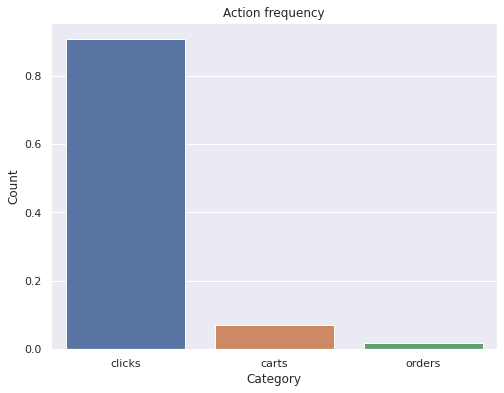

In [10]:
### Actions ###

total_actions = sum(overall_action_counts.values())

plt.figure(figsize=(8,6))
# y: the ratio(frequency) of each action
sns.barplot(x=list(overall_action_counts.keys()), y=[i/total_actions for i in overall_action_counts.values()]);
plt.title(f'Action frequency', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

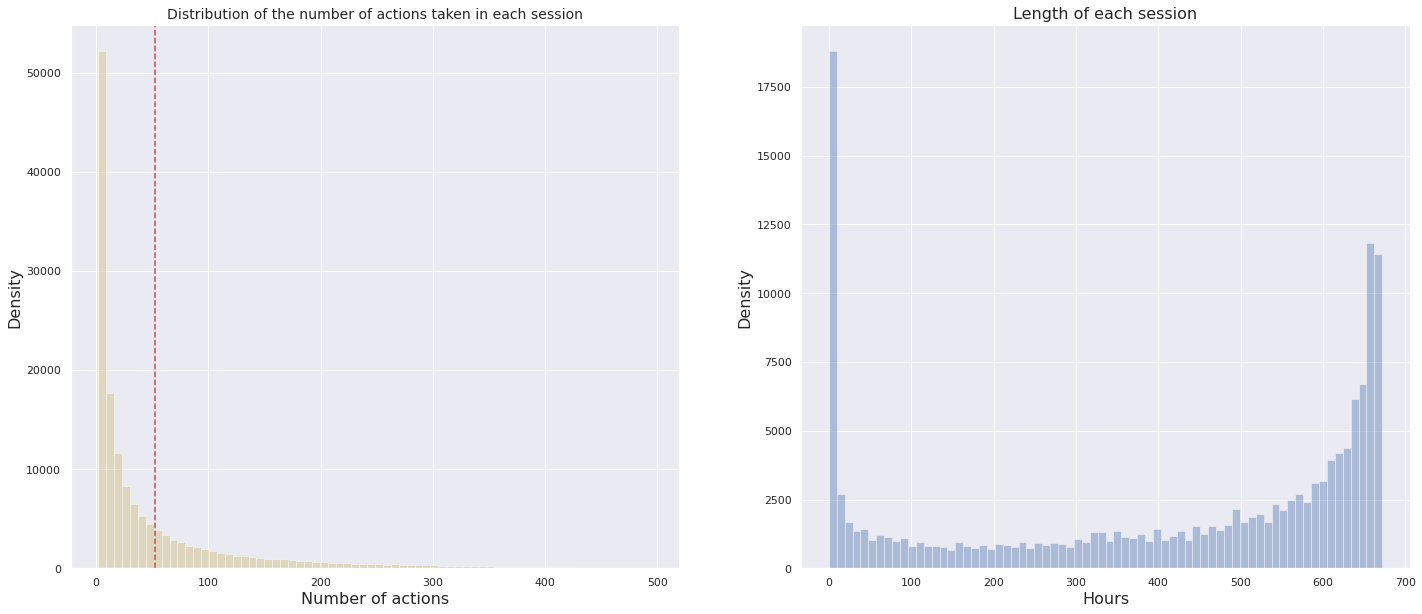

In [11]:
# 이룰어진 action의 개수와 각 섹션의 시간 길이 분포
fig, ax = plt.subplots(1,2, figsize=(24, 10))

p = sns.distplot(sample_train_df['session_length_action'], color="y", bins= 70, ax=ax[0], kde=False)
p.set_xlabel("Number of actions", fontsize = 16)
p.set_ylabel("Density", fontsize = 16)
p.set_title("Distribution of the number of actions taken in each session", fontsize = 14)
p.axvline(sample_train_df['session_length_action'].mean(), color='r', linestyle='--', label="Mean")

p = sns.distplot(sample_train_df['session_length_hours'], color="b", bins= 70, ax=ax[1], kde=False)
p.set_xlabel("Hours", fontsize = 16)
p.set_ylabel("Density", fontsize = 16)
p.set_title("Length of each session", fontsize = 16);

Something seems a bit odd with the minutes plot. All the sessions are capped at 650 hours - this needs looking into .. 🤔

In [12]:
print(f'{round(len(sample_train_df[sample_train_df["session_length_action"]<10])/len(sample_train_df),3)*100}% of the sessions had less than 10 actions')

34.8% of the sessions had less than 10 actions


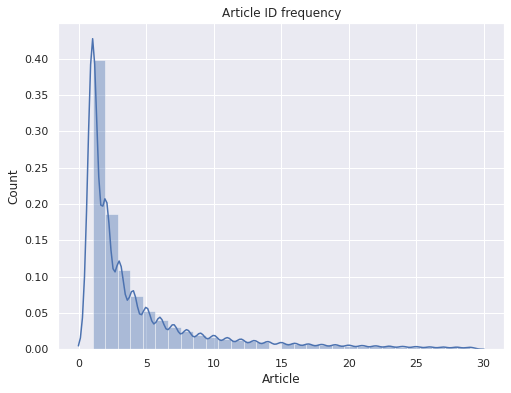

In [13]:
article_id_freq = list(overall_article_id_counts.values())
cut_off = [i for i in article_id_freq if i<30]

plt.figure(figsize=(8,6))
# 전체 article_id 개수가 30개보다 적은 것들의 분포 그래프
sns.distplot(cut_off, bins=30, kde = True)
## kde: 커널밀도추정, 밀집도그래프를 같이 보여줄 것인지
plt.title(f'Article ID frequency', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Article', fontsize=12);

As we can see from the plot above the vast majority of articles have a very small number of actions relating to them. There are some exceptions..

In [14]:
### Look at the most interacted with articles ###
# 오름차순 정렬해서 끝에서부터 5개, 즉 상위 5개 추출
print(f'Frequency of most common articles: {sorted(list(overall_article_id_counts.values()))[-5:]} \n')

# nlargest():  데이터를 오름차순/내림차순(nsmallest) 정렬 후, 위에서 n개의 행을 출력하는 메서드
## df.nlargest(n, columns, keep='first:동일한 값일 경우 위에서부터 출력')
res = nlargest(5, overall_article_id_counts, key = overall_article_id_counts.get)
print(f'IDs for those common articles: {res}')

Frequency of most common articles: [3877, 4259, 4323, 4503, 5000] 

IDs for those common articles: [29735, 1603001, 832192, 1733943, 108125]
